# `CLOUD.jl` - 2D linear advection example

In [60]:
using OrdinaryDiffEq, CLOUD
ENV["MPLBACKEND"]="agg";

Define the physical problem

In [61]:
θ = π/4 # wave angle
a = sqrt(2) # wave speed
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ)))) # end time for one period

initial_data = InitialDataSine(A,k)
conservation_law = LinearAdvectionEquation((a*cos(θ),a*sin(θ)));

Set discretization parameters

In [62]:
M = 4
p = 6
p_map = 6
form = WeakConservationForm(StandardMapping(),LaxFriedrichsNumericalFlux())
strategy = Lazy()

ode_algorithm = CarpenterKennedy2N54()
dt = 0.1*(L/M)/(a*(2*p+1));
write_interval = floor(Int, T/(dt*10));

## Quadrilateral discontinuous Galerkin collocation spectral element method
Set up a `DGSEM` scheme with LG quadrature on quadrilaterals of degree `p` with `M` edges in each direction

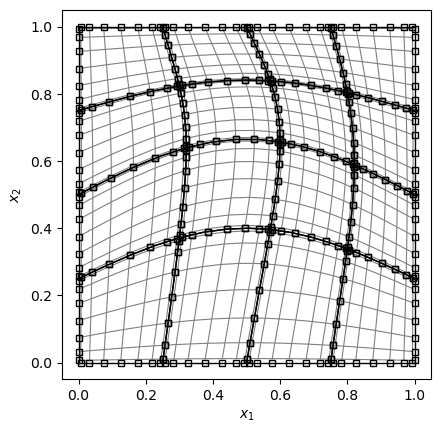

In [63]:
reference_approximation =ReferenceApproximation(
    DGSEM(p), Quad(),
    volume_quadrature_rule=LGQuadrature(),
    facet_quadrature_rule=LGQuadrature(),
    mapping_degree=p_map, N_plot=50)

mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M)), 
    reference_approximation.reference_element, 0.1)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), Lazy(),
     "results/advection_2d_dgsem/", overwrite=true, clear=true)

visualize(spatial_discretization, results_path, "mesh.pdf", 
    plot_volume_nodes=false, grid_lines=true)

Run the solver and plot the solution

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:          102μs / 1365484.4%      11.9KiB / 11887711.6%  

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 eval residual          58.9k    919ms   65.7%  15.6μs    642MiB   46.5%  11.2KiB
   volume terms         58.9k    474ms   33.9%  8.05μs    365MiB   26.5%  6.34KiB
   mass matrix solve    58.9k    189ms   13.5%  3.20μs   50.3MiB    3.7%     896B
   facet terms          58.9k    177ms   12.6%  3.00μs    161MiB   11.7%  2.80KiB
 extrapolate solution   58.9k    166ms   11.8%  2.81μs    120MiB    8.7%  2.09KiB
 eval numerical flux    58.9k    114ms    8.2%  1.93μs    196MiB   14.2%  3.41KiB
 gather externa

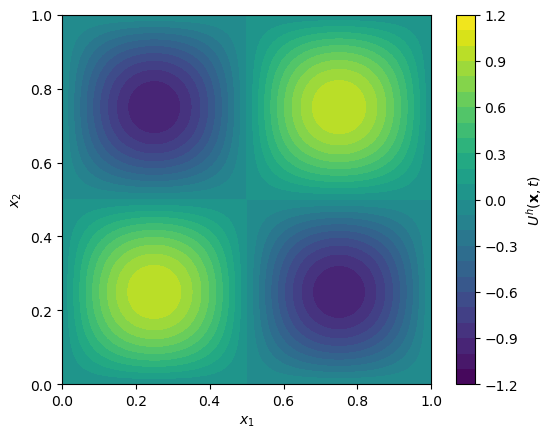

In [64]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    strategy)
save_solution(ode_problem.u0, 0.0, results_path, 0)

CLOUD_reset_timer()
sol = solve(ode_problem, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, write_interval))
CLOUD_print_timer()

save_solution(last(sol.u), last(sol.t), results_path, "final")
plotter = Plotter(spatial_discretization, results_path)
visualize(last(sol.u), plotter, "approx.pdf", u_range=[-1.0,1.0], contours=25,
    label="U^h(\\mathbf{x},t)")


Plot the exact solution (same as initial data)

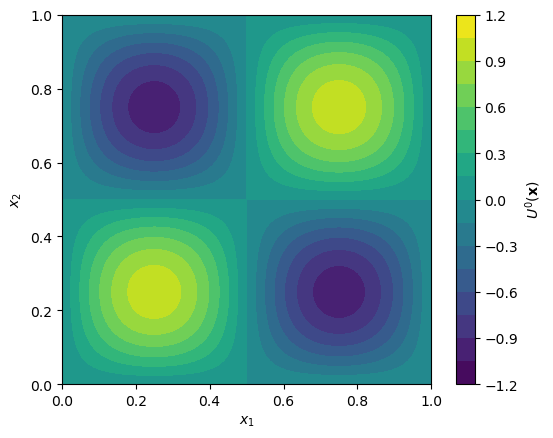

In [65]:
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=17, label="U^0(\\mathbf{x})")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [66]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data)...)
println("Conservation (initial/final/diff):")
println(analyze(conservation_analysis)...)
println("Energy (initial/final/diff):")
println(analyze(energy_analysis)...)

L2 error:
1.581852848357487e-5
Conservation (initial/final/diff):
[-1.8049242656026365e-12][-1.8052209033170286e-12][-2.96637714392034e-16]
Energy (initial/final/diff):
[0.1249999998893287][0.12499998029301698][-1.9596311712222203e-8]


## Triangular modal discontinuous Galerkin method
Set up a `DGMulti` scheme on triangles of degree `p` with `M` edges in each direction

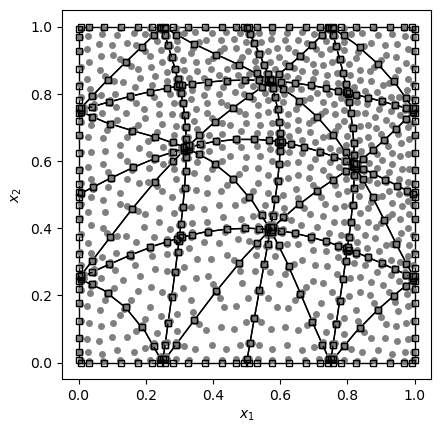

In [67]:
reference_approximation = ReferenceApproximation(
    DGMulti(p), Tri(), mapping_degree=p_map, N_plot=10)

mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M)), 
    reference_approximation.reference_element, 0.1)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), Lazy(),
     "results/advection_2d_dgmulti/", overwrite=true, clear=true)

visualize(spatial_discretization, results_path, "mesh.pdf", 
    plot_volume_nodes=true, grid_lines=false)

Run the solver and plot the solution

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:         86.2μs / 7066672.1%      11.9KiB / 23713408.8%  

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 eval residual           118k    4.72s   77.5%  40.1μs   1.39GiB   51.7%  12.4KiB
   mass matrix solve     118k    3.76s   61.7%  31.9μs    784MiB   28.5%  6.81KiB
   volume terms          118k    659ms   10.8%  5.60μs    518MiB   18.8%  4.50KiB
   facet terms           118k   81.8ms    1.3%   694ns   25.2MiB    0.9%     224B
 eval flux               118k    487ms    8.0%  4.14μs    173MiB    6.3%  1.50KiB
 eval numerical flux     118k    285ms    4.7%  2.42μs    306MiB   11.1%  2.66KiB
 gather externa

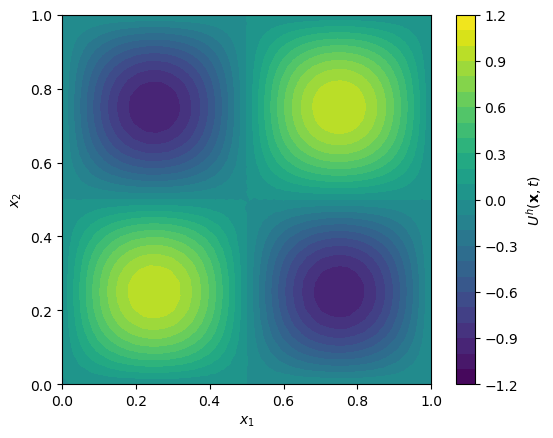

In [68]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    strategy)
save_solution(ode_problem.u0, 0.0, results_path, 0)

CLOUD_reset_timer()
sol = solve(ode_problem, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, write_interval))
CLOUD_print_timer()

save_solution(last(sol.u), last(sol.t), results_path, "final")

plotter = Plotter(spatial_discretization, results_path)
visualize(last(sol.u), plotter, "approx.pdf", u_range=[-1.0,1.0], contours=25,
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [69]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data)...)
println("Conservation (initial/final/diff):")
println(analyze(conservation_analysis)...)
println("Energy (initial/final/diff):")
println(analyze(energy_analysis)...)

L2 error:
0.000163330504634601
Conservation (initial/final/diff):
[-6.848316458189785e-10][-6.848436791620505e-10][-1.2033343071982117e-14]
Energy (initial/final/diff):
[0.1249999630761233][0.12499930023178464][-6.628443386530458e-7]
